# Prompting techniques from https://www.promptingguide.ai/techniques

In [51]:
from dotenv import load_dotenv
from google import genai
from google.genai import types
load_dotenv() 

# Creating the client
# The client gets the API key from the environment variable `GEMINI_API_KEY`.
client = genai.Client()

In [9]:
# Simple test
response = client.models.generate_content(
    model="gemini-2.5-flash", contents="Explain how AI works in a few words"
)
print(response.text)

AI learns patterns from data to make decisions or predictions.


In [14]:
# Zero-shot prompting: No example or demonstration to the LLM
response = client.models.generate_content(
    model="gemini-2.5-flash", 
    contents="Classify the text into neutral, negative or positive: Text: The time off was ok. Sentiment:"
)
print(response.text)

**Positive** (though very mildly so, leaning towards acceptable/satisfactory rather than enthusiastic).

"Ok" indicates that it was acceptable and not negative, implying a basic level of satisfaction.


In [5]:
# Few-shot Enable in-context learning providing demonstration in the
# prompt to steer the model to better performance
prompt = '''
    Classify the sentiment of the text below as **Positive**, **Negative**, or **Neutral**, based on the example format.
    Example:
    <query>
    The time off was ok
    </query>
    <response>
    Neutral
    </response>

    Classify:
    <query>
    I loved that food
    </query>
'''
response = client.models.generate_content(
    model="gemini-2.5-flash", 
    contents=prompt
)
print(response.text)


<response>
Positive
</response>


In [11]:
# Chain-of-Thought enable reasoning before answering. It can be combined with few shot.
# Used in ReAct
prompt = '''
The content below are examples to reason before answering.
Table: João - 2 sales | Maria - 5 sales | Pedro - 3 sales
Question: Who sold more and sales average?
Thinking step by step.
1. Comparing: Maria (5) > Pedro (3) > João (2)
2. Sales sum: 2 + 3 + 5 = 10
3. Average: 10 / 3 = 3,33 (prox)
Answer: Maria sold more; Average was 3,33.

Question: The laptop is not turning on and it's connected to the energy.
Let's think step by step.

Answer the next question below:
'''
question = '''
Question: Which Brazilian states don't have a letter "a" in the name?
'''
response = client.models.generate_content(
    model="gemini-2.5-flash", 
    contents=prompt + question
)
print(response.text)

Let's think step by step.

1.  **Recall/List all Brazilian states:**
    *   Acre
    *   Alagoas
    *   Amapá
    *   Amazonas
    *   Bahia
    *   Ceará
    *   Espírito Santo
    *   Goiás
    *   Maranhão
    *   Mato Grosso
    *   Mato Grosso do Sul
    *   Minas Gerais
    *   Pará
    *   Paraíba
    *   Paraná
    *   Pernambuco
    *   Piauí
    *   Rio de Janeiro
    *   Rio Grande do Norte
    *   Rio Grande do Sul
    *   Rondônia
    *   Roraima
    *   Santa Catarina
    *   São Paulo
    *   Sergipe
    *   Tocantins

2.  **Examine each state name for the presence of the letter "a" (case-insensitive):**
    *   Acre: Contains "A"
    *   Alagoas: Contains "A"
    *   Amapá: Contains "a"
    *   Amazonas: Contains "a"
    *   Bahia: Contains "a"
    *   Ceará: Contains "a"
    *   Espírito Santo: Contains "a"
    *   Goiás: Contains "a"
    *   Maranhão: Contains "a"
    *   Mato Grosso: Contains "a"
    *   Mato Grosso do Sul: Contains "a"
    *   Minas Gerais: Contai

In [10]:
# Without Chain-of-Thought
question = '''
Question: Which Brazilian states don't have a letter "a"?
'''
response = client.models.generate_content(
    model="gemini-2.5-flash", 
    contents=question
)
print(response.text)

There are two Brazilian states that don't have the letter "a" in their names:

1.  **Rondônia**
2.  **Sergipe**


# Meta prompting
Focuses on structure and syntactical aspects of tasks and 
problems rather than specific content details.
The goal is to construct a more abstract, structured way of interacting with LLM.

# Characteristics
1. Structure-oriented: Prioritizes the format and pattern of problems and solutions over specific content.
2. Syntax-focused: Uses syntax as a guiding template for the expected response or solution.
3. Abstract examples: Employs abstracted examples as frameworks, illustrating the structure of problems and solutions without focusing on specific details.
4. Versatile: Applicable across various domains, capable of providing structured responses to a wide range of problems.
5. Categorical approach: Draws from type theory to emphasize the categorization and logical arrangement of components in a prompt.





In [6]:
# Meta prompting
instruction = '''
You are a prompt engineer. Your task is to generate a clear and effective prompt for an AI language model that will help create a concise technical explanation of a given software architecture concept. The explanation should follow this structure:

1. A brief definition (2-3 sentences)
2. A real-world analogy to simplify the concept
3. A short example or use case (code optional)

The target audience is intermediate software developers. Use simple language, avoid unnecessary jargon, and make the result no longer than 300 words.
'''
query = "Generate a prompt for the concept: **Event-Driven Architecture**."
response = client.models.generate_content(
    model="gemini-2.5-flash", 
    contents=instruction + query
)
print(response.text)

Okay, here is the prompt designed for the AI language model:

---

**Prompt for AI Language Model:**

You are a technical writer specializing in software architecture. Your task is to generate a concise explanation of the software architecture concept: **Event-Driven Architecture**.

The explanation is for intermediate software developers. Use simple language and avoid unnecessary jargon.

Follow this exact structure:

1.  **Definition:** Provide a brief, 2-3 sentence definition of Event-Driven Architecture.
2.  **Analogy:** Include a clear, real-world analogy to simplify the concept.
3.  **Example/Use Case:** Offer a short example or common use case where Event-Driven Architecture would be beneficial. Code is optional.

Keep the entire explanation under 300 words. Aim for clarity and immediate understanding.


# Self-consistency
Aims to replace the naive greedy decoding used in chain-of-thought prompting. Sampel multiple, diverse reasoning paths throught few-shot CoT, and use the generations to select the most consistent answer.

Let's repeat the prompt with 1 temperature 5-10 times and get the best result

In [13]:
# Self-consistency
from collections import Counter

instruction = '''
You are a software architect. Think step by step and estimate how many microservices might be needed for an e-commerce platform that includes user management, product catalog, inventory, payment, and order tracking.

Explain your reasoning before stating the final number of microservices.
'''
results = []
for _ in range(5): 
    response = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=instruction,
        config=types.GenerateContentConfig(
            temperature=1.0,
        ),
    )
    answer = response.text.strip()
    results.append(answer)

most_common = Counter(results).most_common(1)
print(f"Most common answer:\n{most_common[0][0]}")
print(results)

Most common answer:
As a software architect, estimating the number of microservices for a complex platform like e-commerce involves identifying distinct functional boundaries, considering scalability, independent deployment, and team autonomy. My approach is to break down the platform into its core business capabilities (bounded contexts), and then identify supporting cross-cutting concerns.

---

### Step-by-Step Reasoning for Microservices Estimation

**1. Identify Core Business Capabilities (Bounded Contexts):**

These are the primary domains that represent distinct areas of the business, each with its own data and logic.

*   **User Management:**
    *   **Scope:** User registration, login (authentication), profile management (address, preferences), roles, permissions (authorization).
    *   **Why a Microservice?** Handles sensitive user data, authentication workflows, and is foundational to most interactions. Needs to be highly available and secure.
    *   **Proposed Service:** 

# Prompt Chaining
Break tasks into smaller tasks, once subtasks have been identified, the LLM is prompted with a subtask and the response is used as input to another prompt.

(Prompt) -> [LLM] -> Response -> [LLM]


In [28]:
# Prompt chaining 1/2

query = '''
Please generate a list of 3 chapters for an eBook titled "Mastering Python". Each chapter should have a title and a brief description (1-2 sentences). Return the chapters in the following format, where each chapter is separated by `###`:

    Chapter 1: [Title]
    Description: [Brief description]

    Chapter 2: [Title]
    Description: [Brief description]
'''
response = client.models.generate_content(
    model="gemini-2.5-flash", 
    contents=query
)
print(response.text)

Chapter 1: Beyond the Basics: Pythonic Paradigms
Description: This chapter delves into Python's unique features like decorators, generators, and context managers, demonstrating how to write more efficient, elegant, and "Pythonic" code. It also covers advanced data structures and functional programming concepts.

###
Chapter 2: Object-Oriented Mastery & Design Patterns
Description: Explore advanced object-oriented programming (OOP) in Python, including inheritance, polymorphism, and abstract base classes. This chapter also introduces common design patterns and their Pythonic implementations for building robust and scalable applications.

###
Chapter 3: Performance, Concurrency, and Deployment
Description: Learn strategies for optimizing Python code performance, including profiling and C extensions. This chapter also covers concurrency with threads and asyncio, and essential considerations for deploying Python applications into production environments.


In [29]:
# Prompt chaining 2\2
chapters = response.text.split('###')

for chapter in chapters:
    # Extract title and description
    title, description = chapter.strip().split('\n')
    title = title.replace("Chapter", "").strip()
    description = description.replace("Description:", "").strip()
    query = f"""
    Write a detailed chapter about '{title}'. The chapter should cover the following:
    - Introduction to the topic.
    - Key concepts explained in simple terms.
    - Example use cases and applications for the concept.
    - Summary at the end of the chapter.

    Chapter description: {description}
    """
    content = client.models.generate_content(
        model="gemini-2.5-flash", 
        contents=query
    )
    
    print(f"Chapter Title: {title}\n")
    print(f"Chapter Description: {description}\n")
    print(f"Chapter Content: {content.text}\n")
    print('-==========-')


Chapter Title: 1: Beyond the Basics: Pythonic Paradigms

Chapter Description: This chapter delves into Python's unique features like decorators, generators, and context managers, demonstrating how to write more efficient, elegant, and "Pythonic" code. It also covers advanced data structures and functional programming concepts.

Chapter Content: # Chapter 1: Beyond the Basics: Pythonic Paradigms

## Introduction: The Spirit of Python

Welcome to "Beyond the Basics: Pythonic Paradigms"! You've likely mastered Python's fundamental syntax – variables, loops, functions, and basic data structures. But Python is more than just a programming language; it has a unique philosophy, a "way" of doing things that goes beyond mere correctness. This "way" is what we call **"Pythonic" code**.

Writing Pythonic code means embracing the language's idioms, best practices, and built-in features to produce code that is not just functional, but also:

*   **Readable:** Easy for humans to understand, often re

# Tree of Thoughts

Generalizes over chain-of-thought and encourages exploration over thoughts that serve as intermediate steps for general problem solving.

Thought represent coherent language sequences that serve as intermediate steps toward solving a problem. This enables to self-evaluation. 

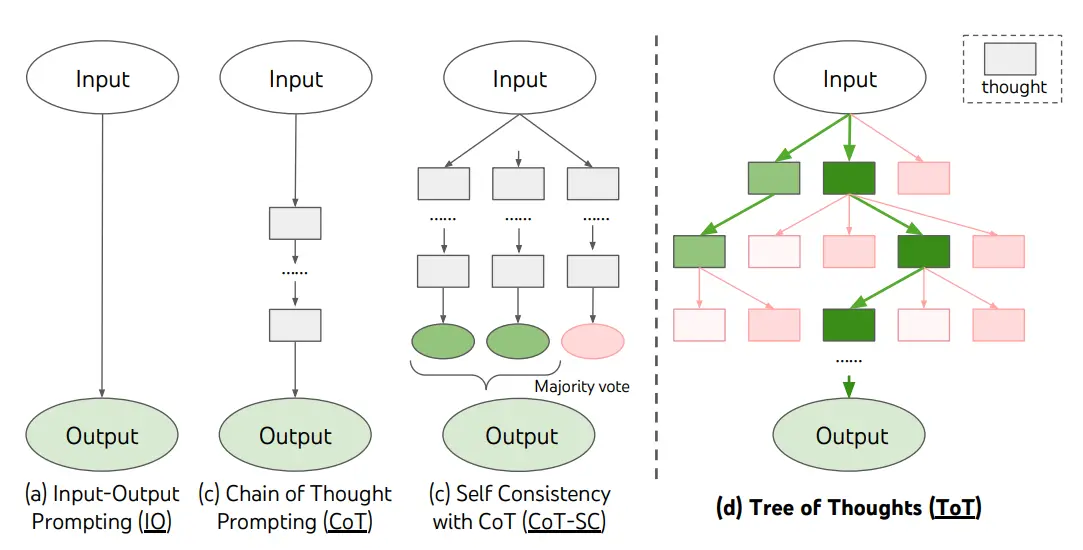

Through search strategies like BFS, DFS, or beam search, the model evaluates, prunes, and backs up when necessary. Less promising branches are discarded (“impossible” or “too big/small”), while viable paths are expanded. This process continues iteratively until a high-quality solution emerges that aligns with commonsense reasoning and overall goals.

In [33]:
# ToT

def generate_thoughts(prompt: str, n: int = 3):
    thoughts = []
    for _ in range(n):
        response = client.models.generate_content(
            model="gemini-2.5-flash", 
            contents=prompt
            )
        thoughts.append(response.text.strip())
    return thoughts


def evaluate_thought(thought: str):
    eval_prompt = f"""
Evaluate the following solution attempt. Respond only with 'yes', 'no', or 'maybe'.

Thought:
{thought}

Does it seem like a valid or potentially valid path to solving the problem?
"""
    response = client.models.generate_content(
            model="gemini-2.5-flash", 
            contents=eval_prompt
            )
    decision = response.text.lower().strip()
    if "yes" in decision:
        return "yes"
    elif "no" in decision:
        return "no"
    else:
        return "maybe"


def tree_of_thoughts(initial_prompt: str, max_depth=3):
    tree = [{"thought": initial_prompt, "depth": 0}]
    solutions = []

    while tree:
        node = tree.pop(0)
        print(f"\nExploring thought: {node['thought'][:30]}...")

        if node["depth"] >= max_depth:
            continue

        thoughts = generate_thoughts(node["thought"], n=3)

        for t in thoughts:
            evaluation = evaluate_thought(t)
            print(f"Thought: {t[:30]} → Eval: {evaluation}")

            if evaluation == "yes":
                solutions.append(t)
            elif evaluation == "maybe":
                tree.append({"thought": t, "depth": node["depth"] + 1})

    return solutions

initial_prompt = """
You are given the numbers 4, 7, 8, and 8.
Using +, -, *, / and parentheses, find expressions that result in the number 24.
Start by generating possible intermediate steps toward solving this problem.
"""

results = tree_of_thoughts(initial_prompt)
print("\nSolutions found:")
for r in results:
    print(r)





🌱 Exploring thought: 
You are given the numbers 4, ...
🧠 Thought: To find expressions that resul → Eval: yes
🧠 Thought: To find expressions that resul → Eval: yes
🧠 Thought: To find expressions that resul → Eval: yes

Solutions found:
To find expressions that result in 24 using the numbers 4, 7, 8, and 8, and the operations +, -, *, /, and parentheses, we can explore several intermediate steps and strategies.

**Numbers available:** {4, 7, 8, 8}
**Target:** 24

Here's a thought process, generating intermediate steps and leading to solutions:

**Strategy 1: Aim for factors of 24 (e.g., 3, 4, 6, 8, 12) and multiply.**

*   **Aim for 3:**
    *   Can we make 3 from two numbers? Yes, `7 - 4 = 3`.
    *   Numbers remaining: {8, 8}.
    *   Now, we need to multiply 3 by something to get 24. `3 * 8 = 24`.
    *   Used numbers: 7, 4, 8. One 8 is left.
    *   How to incorporate the last 8? We can multiply by `(8 / 8)` (which is 1) or add `(8 - 8)` (which is 0).
    *   **Solution 1:** `(7 - 4

# Automatic Prompt Engineer (APE)
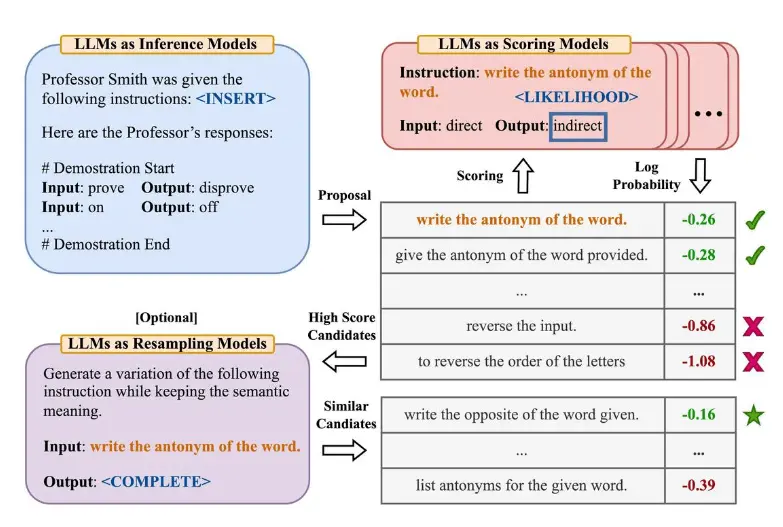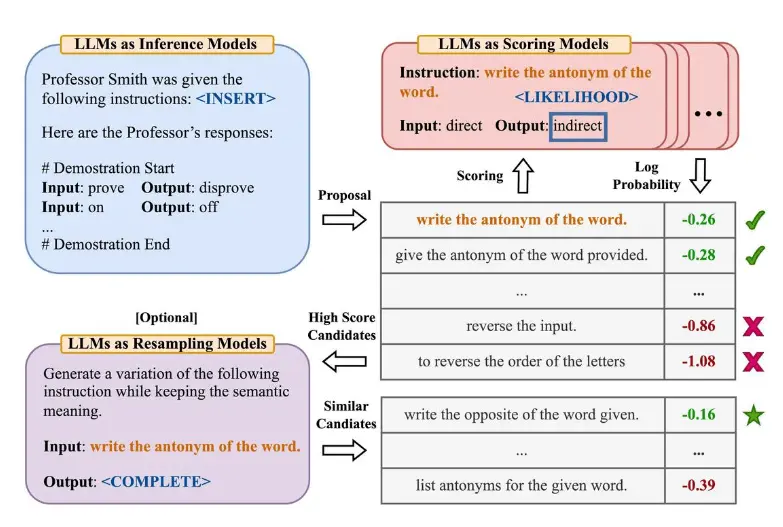


A framework for automatic instruction generation and selection. A LLM that is given output demonstrations to generate instruction candidates for a task. These candidate solutions will guide the search procedure. The instructions are executed using a target model, and then the most appropriate instruction is selected based on computed evaluation scores.

In [36]:
# APE 1/2
examples = [
    ("1", "one"),
    ("15", "fifteen"),
    ("30", "thirty"),
    ("42", "forty-two")
]

examples_str = "\n".join([f"{i}. Input: {x} → Output: {y}" for i, (x, y) in enumerate(examples, 1)])

prompt_gen_query = f"""
You are a prompt engineer. Your task is to write **5 different prompt candidates** that instruct a large language model (LLM) to convert an integer number into its name in **English words**.

Here are examples of the task:
{examples_str}

Please return 5 prompt candidates in a list format, be objective, only return the list, no other information.
"""
response_1 = client.models.generate_content(
            model="gemini-2.5-flash", 
            contents=prompt_gen_query
            )

prompt_candidates = [
    p.strip("- ").strip()
    for p in response_1.text.split("\n")
    if p.strip() and p.strip()[0].isdigit() == False
]

print("Prompt candidates:\n")
for i, p in enumerate(prompt_candidates, 1):
    print(f"{i}. {p}\n")

Prompt candidates:

1. *   "Convert the numerical input into its full English word form. For instance, '1' should become 'one', and '42' should become 'forty-two'."

2. *   "You are an expert numerical word translator. When given an integer, your only output should be its correct English word spelling, with no additional text or formatting whatsoever."

3. *   "I will provide an integer. Your task is to return only its English word name. Follow these examples:

4. *   "Generate only the English word representation for any integer I provide. Do not include any explanations, preambles, or punctuation other than standard hyphens (e.g., 'twenty-three')."

5. *   "Provide the English word equivalent of the given integer. Output only the words."



In [41]:
import google.generativeai as genai
import time
from difflib import SequenceMatcher

evaluation_set = [
    ("57", "fifty-seven"),
    ("99", "ninety-nine"),
    ("100", "one hundred"),
    ("73", "seventy-three"),
]

def similarity(a, b):
    return SequenceMatcher(None, a.lower(), b.lower()).ratio()

results = []

print("\nEvaluating prompt candidates...\n")

for i, candidate_prompt in enumerate(prompt_candidates, 1):
    score = 0
    total = 0
    print(f"Prompt {i}: {candidate_prompt}\n")

    for inp, expected in evaluation_set:
        full_prompt = f"{candidate_prompt}\nInput: {inp}"
        response = client.models.generate_content(
            model="gemini-2.5-flash", 
            contents=full_prompt
            )
        output = response.text.strip()
        sim = similarity(output, expected)
        print(f"   - Input: {inp} | Output: {output} | Target: {expected} | Score: {sim:.2f}")
        score += sim
        total += 1
        time.sleep(0.5)

    avg_score = score / total
    results.append((avg_score, candidate_prompt))
    print(f"Average score: {avg_score:.2f}\n{'-'*50}\n")

best_prompt = max(results, key=lambda x: x[0])
print(f"Best Prompt:\n{best_prompt[1]}\nAvg Score: {best_prompt[0]:.2f}")



Evaluating prompt candidates...

Prompt 1: *   "Convert the numerical input into its full English word form. For instance, '1' should become 'one', and '42' should become 'forty-two'."

   - Input: 57 | Output: Fifty-seven | Target: fifty-seven | Score: 1.00
   - Input: 99 | Output: ninety-nine | Target: ninety-nine | Score: 1.00
   - Input: 100 | Output: One hundred | Target: one hundred | Score: 1.00
   - Input: 73 | Output: seventy-three | Target: seventy-three | Score: 1.00
Average score: 1.00
--------------------------------------------------

Prompt 2: *   "You are an expert numerical word translator. When given an integer, your only output should be its correct English word spelling, with no additional text or formatting whatsoever."

   - Input: 57 | Output: fifty-seven | Target: fifty-seven | Score: 1.00
   - Input: 99 | Output: ninety-nine | Target: ninety-nine | Score: 1.00
   - Input: 100 | Output: one hundred | Target: one hundred | Score: 1.00
   - Input: 73 | Output: se

ClientError: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'location': 'global', 'model': 'gemini-2.5-flash'}, 'quotaValue': '10'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '43s'}]}}

# Active-Prompt

Active-Prompt to adapt LLM to different task-specific example prompts  (annotated with human-designed CoT reasoning).
The first step is to query the LLM with or without a few CoT examples. k possible answers are generated for a set of training questions. An uncertainty metric is calculated based on the k answers (disagreement used). The most uncertain questions are selected for annotation by humans. The new annotated exemplars are then used to infer each question.

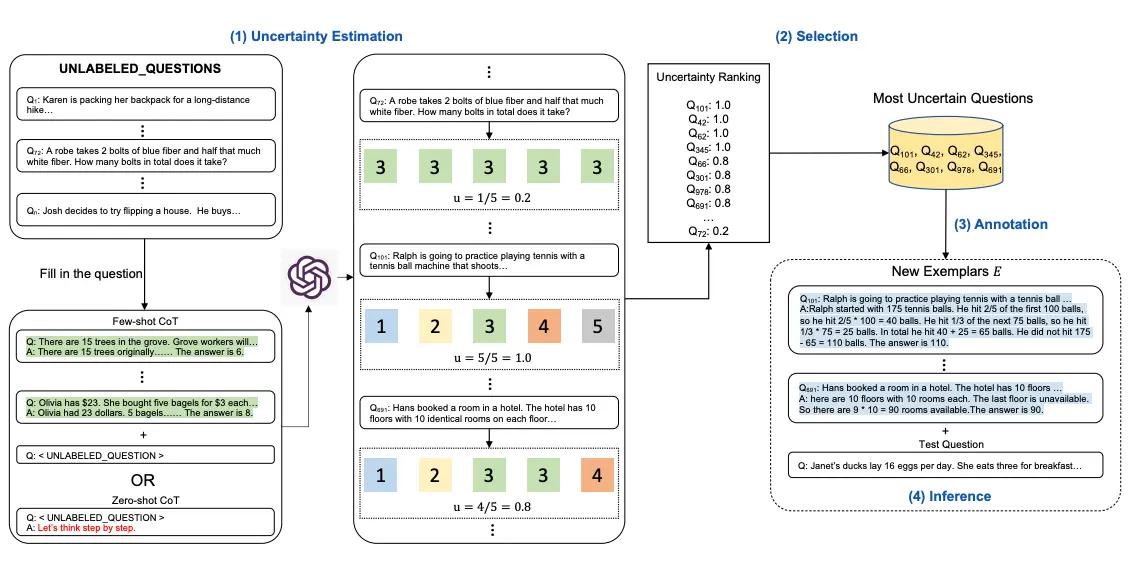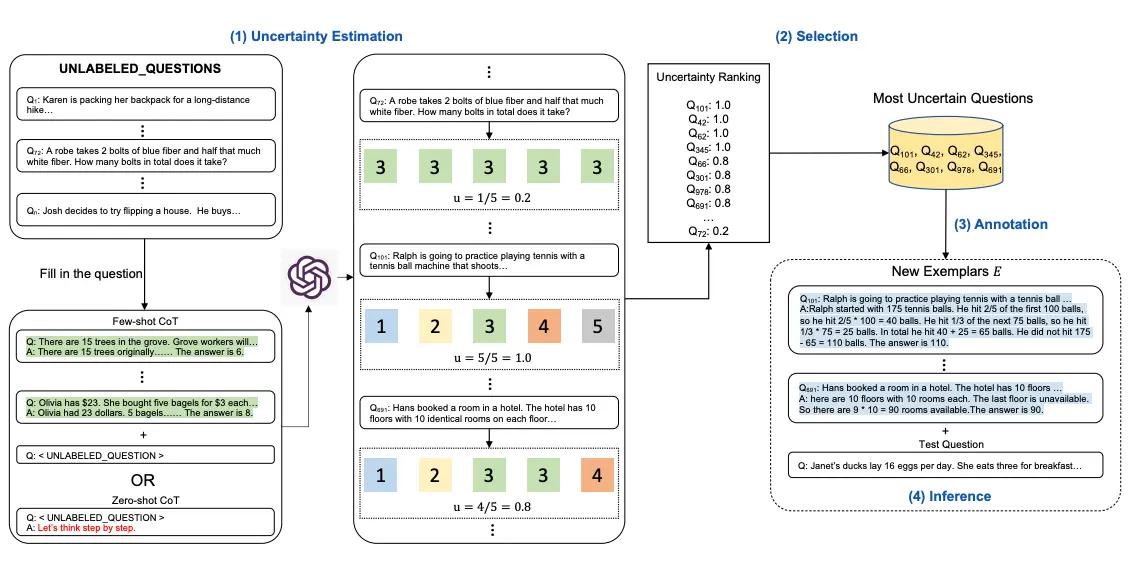

In [50]:
import google.generativeai as genai

initial_few_shot_examples = [
    ("I can't log in with my email and password", "login_issues"),
    ("I was charged twice this month", "billing"),
]

unlabeled_pool = [
    "The app crashes every time I try to upload a picture.",
    "Do you have a mobile app for Android?",
    "My screen goes blank after the last update.",
    "Can you add support for dark mode, please?",
    "How can I reset my forgotten password?",
]

human_annotator_ground_truth = {
    "The app crashes every time I try to upload a picture.": "bug_report",
    "Do you have a mobile app for Android?": "general_question",
    "My screen goes blank after the last update.": "bug_report",
    "Can you add support for dark mode, please?": "feature_request",
    "How can I reset my forgotten password?": "login_issues",
}

possible_categories = ["login_issues", "billing", "bug_report", "feature_request", "general_question"]


def find_most_uncertain_examples(unlabeled_data, base_examples, n_samples=2, k=2):
    uncertainty_scores = []

    for text in unlabeled_data:
        prompt = f"Classify the message into one of these categories: {', '.join(possible_categories)}\n\n"
        for ex_text, ex_label in base_examples:
            prompt += f"Message: {ex_text}\nCategory: {ex_label}\n\n"
        prompt += f"Message: {text}\nCategory:"       
        predictions = []
        for _ in range(n_samples):
            response = client.models.generate_content(
                model="gemini-2.5-flash",
                contents=prompt,
                config=types.GenerateContentConfig(
                    candidate_count=1, 
                    temperature=0.9,
                ),
            )
            predicted_label = response.text.strip().split('\n')[0]
            if predicted_label in possible_categories:
                 predictions.append(predicted_label)

        # Calcula a incerteza: 1 - (frequência da resposta mais comum)
        # Se todas as 10 respostas forem iguais, incerteza = 1 - (10/10) = 0 (muito confiante)
        # Se as respostas forem divididas 5/5, incerteza = 1 - (5/10) = 0.5 (muito incerto)
        if not predictions:
            uncertainty = 1.0 # Máxima incerteza se não houver predições válidas
        else:
            count = Counter(predictions)
            most_common_freq = count.most_common(1)[0][1] / len(predictions)
            uncertainty = 1.0 - most_common_freq

        print(f"  - Texto: '{text[:30]}...' -> Incerteza: {uncertainty:.2f} | Votos: {dict(count)}")
        uncertainty_scores.append((uncertainty, text))
    uncertainty_scores.sort(key=lambda x: x[0], reverse=True)
    return [text for uncertainty, text in uncertainty_scores[:k]]

most_confusing_examples = find_most_uncertain_examples(
    unlabeled_pool,
    initial_few_shot_examples,
    n_samples=10, 
    k=2     
)

print(f"\nModelo identificou os exemplos mais incertos:\n1. '{most_confusing_examples[0]}'\n2. '{most_confusing_examples[1]}'")
final_few_shot_examples = initial_few_shot_examples.copy()
for text in most_confusing_examples:
    correct_label = human_annotator_ground_truth[text]
    final_few_shot_examples.append((text, correct_label))
    print(f"  - Humano rotulou: '{text}' como '{correct_label}'")

new_ticket_to_classify = "My app won't open after I installed the new version."
final_prompt = "Classify the following user messages into one of the categories:\n" \
               "login_issues, billing, bug_report, feature_request, general_question\n\n"

for ex_text, ex_label in final_few_shot_examples:
    final_prompt += f"Message: {ex_text}\nCategory: {ex_label}\n\n"

final_prompt += f"Message: {new_ticket_to_classify}\nCategory:"


print("Prompt: ", final_prompt)

final_response = client.models.generate_content(
    model="gemini-2.5-flash",
    contents=final_prompt
)

print(f"Category '{new_ticket_to_classify}': {final_response.text.strip()}")

  - Texto: 'The app crashes every time I t...' -> Incerteza: 0.00 | Votos: {'bug_report': 10}


ClientError: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.QuotaFailure', 'violations': [{'quotaMetric': 'generativelanguage.googleapis.com/generate_content_free_tier_requests', 'quotaId': 'GenerateRequestsPerMinutePerProjectPerModel-FreeTier', 'quotaDimensions': {'model': 'gemini-2.5-flash', 'location': 'global'}, 'quotaValue': '10'}]}, {'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google.rpc.RetryInfo', 'retryDelay': '41s'}]}}

# Directional Stimulus Prompting

Steer the LLM to respond in a specific way without being explicit about how to answer but by using hints.

The LLM receives 2 inputs: original entry + stimulus, improving the output.

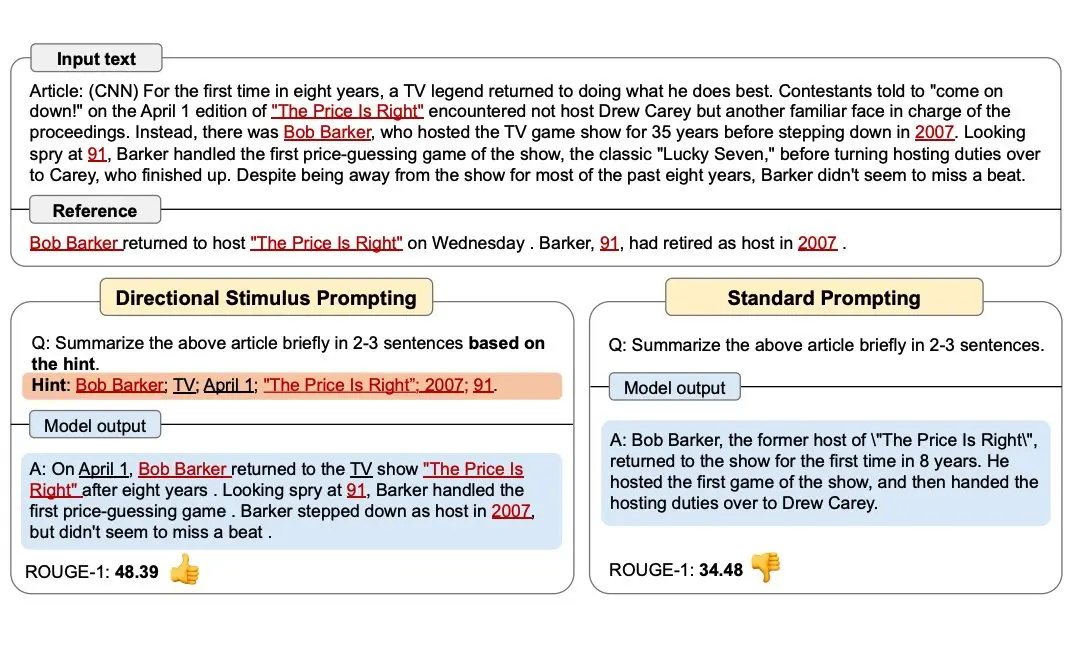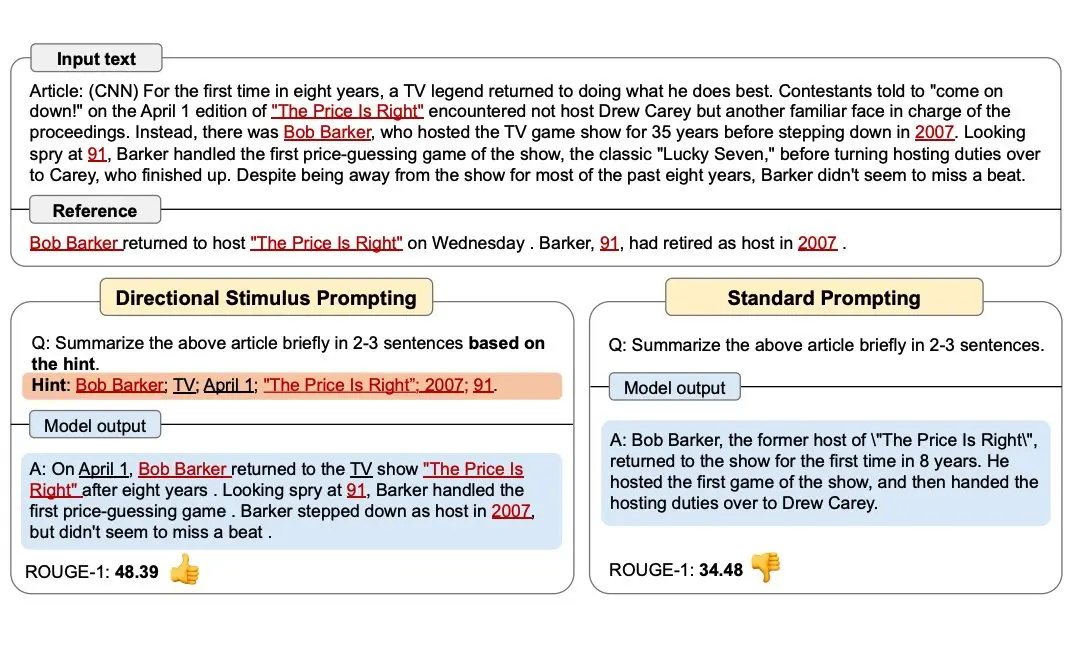

In [48]:
# Add clear hints to guide the model.
prompt_with_dsp = """
    Summarize the concept of quantum computing for a layperson.

    **[Directional Stimulus]**
    - **Focus:** Use a simple analogy to explain 'qubits' and 'superposition'.
    - **Objective:** The text should spark curiosity without getting deep into complex mathematics.
    - **Structure:** Start with an attention-grabbing question and end by explaining a future practical application, like developing new medicines.
    - **Tone:** Didactic and fascinating.
    """

response = client.models.generate_content(
    model="gemini-2.5-flash",
    contents=prompt_with_dsp
)

print(response.text)

Imagine a computer that doesn't just process information in a straight line, but explores every possibility *at once*. Sound like science fiction? Welcome to the fascinating world of quantum computing!

At its heart, quantum computing isn't just about making faster versions of our current devices; it's about a fundamentally new way of handling information. Our everyday computers use "bits" that are like simple light switches: they're either ON (representing a 1) or OFF (representing a 0). But quantum computers use something far more intriguing called a "qubit."

Think of a qubit not as a simple light switch, but as a **light dimmer**. It can be OFF, ON, or, astonishingly, *somewhere in between* both states simultaneously. This mind-bending ability to exist in multiple states at once is called **superposition**. It's like having a coin spinning in the air: until it lands, it's neither heads nor tails, but magically *both* at the same time.

This means a quantum computer doesn't have to 

# PAL (Program-Aided Language Models)

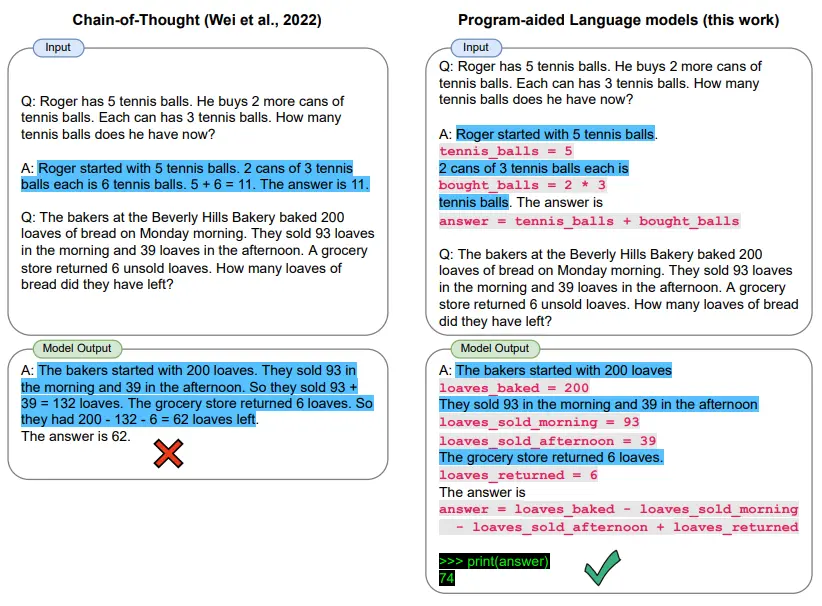

LLM read natural languagem problems and generate programs as intermediate reasoning steps. We use few shot including exemples about how to reason.


In [56]:
# PAL
import ast

def run_code_and_get_last_result(code: str):
    try:
        parsed = ast.parse(code)
        *body, last = parsed.body
        if isinstance(last, ast.Expr):
            exec(compile(ast.Module(body=body, type_ignores=[]), filename="<ast>", mode="exec"))
            return eval(compile(ast.Expression(last.value), filename="<ast>", mode="eval"))
        else:
            exec(code)
            return None
    except Exception as e:
        return f"Error: {e}"


DATE_UNDERSTANDING_PROMPT = """
# Q: 2015 is coming in 36 hours. What is the date one week from today in MM/DD/YYYY?
# If 2015 is coming in 36 hours, then today is 36 hours before.
from datetime import datetime
today = datetime(2015, 1, 1) - relativedelta(hours=36)
# One week from today,
one_week_from_today = today + relativedelta(weeks=1)
# The answer formatted with %m/%d/%Y is
one_week_from_today.strftime('%m/%d/%Y')

# Q: The first day of 2019 is a Tuesday, and today is the first Monday of 2019. What is the date today in MM/DD/YYYY?
# If the first day of 2019 is a Tuesday, and today is the first Monday of 2019, then today is 6 days later.
from datetime import datetime
today = datetime(2019, 1, 1) + relativedelta(days=6)
# The answer formatted with %m/%d/%Y is
today.strftime('%m/%d/%Y')

# Q: The concert was scheduled to be on 06/01/1943, but was delayed by one day to today. What is the date 10 days ago in MM/DD/YYYY?
# If the concert was scheduled to be on 06/01/1943, but was delayed by one day to today, then today is one day later.
from datetime import datetime
today = datetime(1943, 6, 1) + relativedelta(days=1)
# 10 days ago,
ten_days_ago = today - relativedelta(days=10)
# The answer formatted with %m/%d/%Y is
ten_days_ago.strftime('%m/%d/%Y')

# Q: It is 4/19/1969 today. What is the date 24 hours later in MM/DD/YYYY?
# It is 4/19/1969 today.
from datetime import datetime
today = datetime(1969, 4, 19)
# 24 hours later,
later = today + relativedelta(hours=24)
# The answer formatted with %m/%d/%Y is
today.strftime('%m/%d/%Y')

# Q: Jane thought today is 3/11/2002, but today is in fact Mar 12, which is 1 day later. What is the date 24 hours later in MM/DD/YYYY?
# If Jane thought today is 3/11/2002, but today is in fact Mar 12, then today is 3/1/2002.
from datetime import datetime
today = datetime(2002, 3, 12)
# 24 hours later,
later = today + relativedelta(hours=24)
# The answer formatted with %m/%d/%Y is
later.strftime('%m/%d/%Y')

# Q: Jane was born on the last day of Feburary in 2001. Today is her 16-year-old birthday. What is the date yesterday in MM/DD/YYYY?
# If Jane was born on the last day of Feburary in 2001 and today is her 16-year-old birthday, then today is 16 years later.
from datetime import datetime
today = datetime(2001, 2, 28) + relativedelta(years=16)
# Yesterday,
yesterday = today - relativedelta(days=1)
# The answer formatted with %m/%d/%Y is
yesterday.strftime('%m/%d/%Y')

# Q: {question}
""".strip() + '\n'

question = "Today is 27 February 2023. I was born exactly 25 years ago. What is the date I was born in MM/DD/YYYY?"

response = client.models.generate_content(
    model="gemini-2.5-flash",
    contents=DATE_UNDERSTANDING_PROMPT.format(question=question)
)

print('Function exec')
run_code_and_get_last_result(response.text)


Function exec


'02/27/1998'